## Import labels

In [1]:
import numpy as np
from numpy.linalg import inv
import spectral
from PIL import Image
import os
import matplotlib.pyplot as plt
import utils
import tifffile
from sklearn.cluster import KMeans
from sklearn import metrics 
from scipy.spatial.distance import cdist
from os import listdir
from sklearn.metrics import f1_score

from sklearn.cluster import KMeans
from sklearn import metrics 
from scipy.spatial.distance import cdist 
from sklearn.metrics import jaccard_score
import time

In [4]:
#### Accès aux données à changer en fonction du chemain
data_dir = './data/' 
img_name = listdir(data_dir) 
img_name=img_name[:-1]
print(img_name)

data_planet = './planet_crop/' ## Données planète 
img_name_planet = listdir(data_planet) 
print(img_name_planet)

['2019_04_18_M', '2019_05_03_M', '2019_05_08_M', '2019_05_18_M', '2019_05_28_M', '2019_06_07_M', 'label']
['planet_image_crop.tif', 'planet_label_crop.tif']


### Preprossessing des données 

In [7]:
def get_dataset(data_dir, bands):
    labels = []
    data = []
    sizes= []
    img_name = listdir(data_dir)[:-1]
    
    for e in img_name : 
        if e!='label':
            data_im, label_im = utils.get_batch(bands, e, all = False)
            sizes.append(data_im.shape[0:2])
            flatten_labels = label_im.flatten()
            flatten_data = [data_im[:,:,i].flatten() for i in range(len(bands))]
            data.append(flatten_data)
            labels.append(flatten_labels)

    return data, labels, sizes

#### fonction permettant d'avoir accès aux données et de les transformer en tableaux
###  return - data:  tableau contenant les bandes spectrales de tailles pixels x beandes spectrales
####        - labels : tableaux labélises (pixel de plastique = 1)
####        - sizes : liste contenant les tailles d'origines de chacunes des images 

In [8]:
bands = ['B01','B02','B03','B04','B05','B06','B07','B08','B8A','B09','B11','B12']
data_images, labels_images, sizes = get_dataset(data_dir, bands)

In [9]:
train_Images, train_labels, train_sizes = data_images[0:4], labels_images[0:4], sizes[0:4]
test_Images, test_labels, test_sizes = data_images[4:], labels_images[4:], sizes[4:]

## Calcul de la signature spectrale

On utilise un K-Means sur les 4 premières images et sur les 12 bandes spectrales pour extraires l'abondance map des images. 

#### 1° Calcul des endmembers pour l'eau et la terre

In [10]:
### On applique un k-means avec n_clusters = 2 pour identifier les endmermbers sur chaque bandes spectrales
### et pour chaque image.
def extract_clusters(data_images):
    nb_images = len(data_images) ## Nombres d'images utiliser pour la modélisation
    clusters_sea = []
    clusters_earth = []
    for i in range(nb_images):
        X = np.transpose(data_images[i])
        kmeans = KMeans(n_clusters=2,  init='k-means++', n_init=10, max_iter=1000)
        kmeans.fit(X)
        earth_index = kmeans.labels_[0]
        sea_index = kmeans.labels_[-1]
        clusters_earth.append(kmeans.cluster_centers_[earth_index])
        clusters_sea.append(kmeans.cluster_centers_[sea_index])
    
    ### On calcule ensuite la moyenne 
    EM_sea =[] # Liste de endmembers pour chaque bande spectrales
    EM_earth =[]
    s_earth = 0
    s_sea = 0
    for i in range(len(bands)):
        for j in range(nb_images):
            s_sea+= clusters_sea[j][i]
            s_earth+= clusters_earth[j][i]
        EM_sea.append(s_sea/nb_images)
        EM_earth.append(s_earth/nb_images)
        
    return EM_sea, EM_earth

La stratégie prise en compte ici est d'appliquer un K-means sur chacun des images pour identifier les classes des pixels sur une image et extraire les culsters (noyeux de chacune des classes) : il s'agit d'une modélisation de la signature spectrale. On calcule ensuite la moyenne des clusters pour obtenir ce qu'on appelle le endmember (signature spectrale caractéristique d'un classe de pixel). 

Encore une fois, il s'agit d'une modélisation qui pourrait être plus précise. 
Plusieurs axes d'étude peuvent être envisagés :

    ==> Identifier plus de classes que simplement eau, terre, plastique (la côte, la végétation etc...)
    ==> Faire une moyenne sur une plus grande quantité de données
    ==> Utiliser une technique de clustering plus avancée que K-means

#### 2° Calcul des endmembers pour le plastique

A partir des labels, je vais identifier les signatures spectrales du plastique.

In [11]:
def extract_plastic_signatures(data_images, labels_images):
    nb_images = len(data_images)
    XY_plastic = [] ## Coordonnées plastiques
    for i in range(nb_images):
        list_ = []
        image_label = labels_images[i].reshape(sizes[i])
        for k in range(sizes[i][0]):
            for j in range(sizes[i][1]):
                if image_label[k][j] == 1 :
                    list_.append((k,j))

        XY_plastic.append(list_) ### Coordonnées de plastiques sur chacune des images 

    EM_plastic = []

    for k in range(len(bands)):
        s_plastic = 0
        count = 0
        for i in range(nb_images):
            image_data = np.array(data_images[i]).reshape((sizes[i][0],sizes[i][1],12)) ## on retransforme en image 
            for coord in XY_plastic[i]: ## Pour chaque coordonnées 
                s_plastic+= image_data[coord[0]][coord[1]][k] ## On somme les signatures spectrales pour une bande 
                count+=1 ## On fait la moyenne sur toutes les images
        EM_plastic.append(s_plastic/count)
    return EM_plastic

Etant la très faible proportion de pixels de plastiques dans nos images (nb_pixels_plastics <<<<<<< Nb_pixels), on a suggéré d'extraire les signatures spectrales de plastique et de faire une moyenne sur toutes les images. 

#### 3° Modélisation de l'abondance à partir des Endmembers

In [12]:
def estimate_abundance(E,x): ## Pour un pixel donné on calcul l'abondance à partir d'un endmember
    ### estimation parfaite
    E_squared = np.dot(np.transpose(E),E)
    inv_E_squared = inv(E_squared)
    AB = np.dot(np.dot(inv_E_squared, np.transpose(E)), x)
    
    return AB
    

In [13]:
def estimate_abundance_e(EM_plastic, x , R): #### Calcul de l'abondance d'après l'estimation cf pdf
    R_inv = np.linalg.inv(R)
    A1 = np.dot(np.transpose(EM_plastic),np.dot(R_inv,EM_plastic))
    B1 = np.dot(R_inv, EM_plastic)
    res1 = np.dot(1/A1 * np.transpose(B1),x)
    
    return res1

Ici la formule utilisée pour modélisé l'abondance d'un pixel est l'éstimation de la solution de l'équation classique de l'abondance.
Vous trouverez la formule dans ce PDF : https://www.researchgate.net/publication/253447229_Unsupervised_Clustering_and_Spectral_Unmixing_for_Feature_Extraction_Prior_to_Supervised_Classification_of_Hyperspectral_Images

Il exsite surement une modélisation plus précise.

## Testons notre modélisation

In [14]:
### Exctraction des signatures spectrales 
EM_sea, EM_earth = extract_clusters(train_Images)
EM_plastic = extract_plastic_signatures(train_Images, train_labels)

### On crée la matrice des end_members 
E = np.array([EM_plastic, EM_sea, EM_earth])
E = np.transpose(E) ### N'oubliez pas de transposer la matrice 

In [15]:
### première image 
def get_aboundance(test_images): ### with modelisation
    classification_pixel = []
    for image in test_images :
        data_aboundance = []
        R =  np.corrcoef(image)
        for i in range(len(image[0][:])):
            #AB = estimate_abundance(E,np.array(image)[:,i])
            ab = estimate_abundance_e(EM_plastic,np.array(image)[:,i], R)
            data_aboundance.append(ab)
       
        ab_max = np.max(data_aboundance)
        for k in range(len(data_aboundance)):
            if data_aboundance[k] < 0.85*ab_max: ### critère de 85%
                data_aboundance[k]=0
            else :
                data_aboundance[k]=1
        classification_pixel.append(data_aboundance)
    return classification_pixel

In [16]:
def get_aboundance_plastic(test_images): ### with perfect solution
    classification_pixel = []
    for image in test_images :
        data_aboundance = []
        for i in range(len(image[0][:])):
            AB = estimate_abundance(E,np.array(image)[:,i])
            ind = AB.argmax()
            if ind == 0 : ## Dans la matrice E, plastique est à la position 0 
                data_aboundance.append(1)
            else : 
                data_aboundance.append(int(0))
        classification_pixel.append(data_aboundance)
    return classification_pixel

In [18]:
start = time.time()
classification_pixel = get_aboundance_plastic(data_images)
end = time.time()


Temps de calul :  87.08
Temps de calul par image :  43.54


In [20]:
print("Temps de calul : ", int(100*(end - start))/100)
print("Temps de calul par image : ", int(100*(end - start)/len(data_images))/100)

Temps de calul :  87.08
Temps de calul par image :  14.51


In [24]:
len(sizes)

6

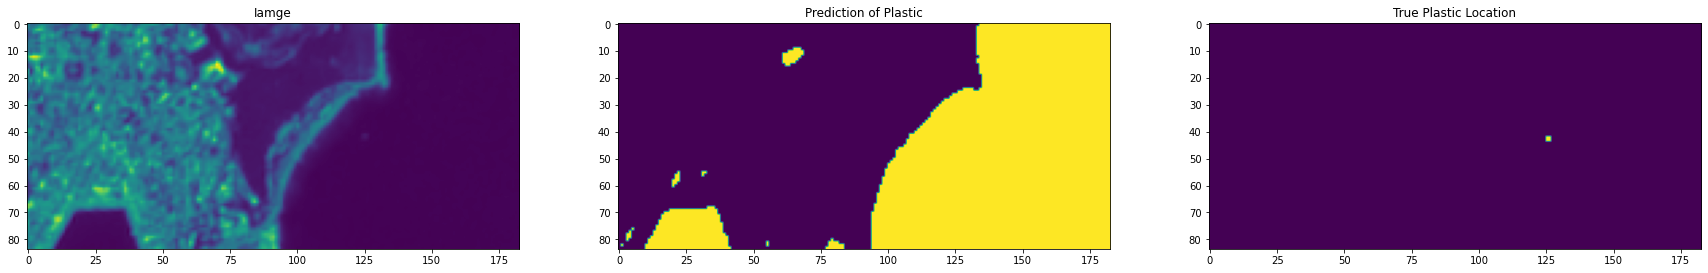

Jaccard score pour l'image 1 : 0.0


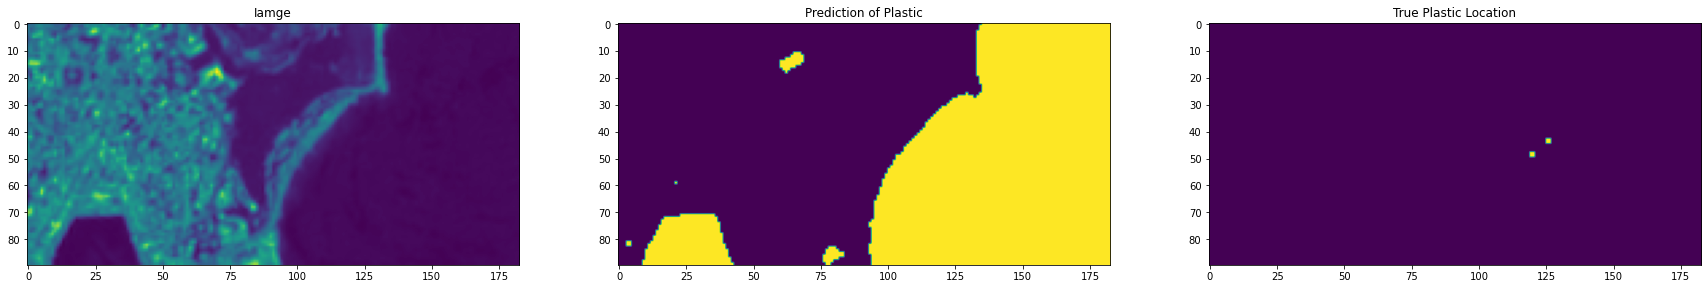

Jaccard score pour l'image 2 : 0.0


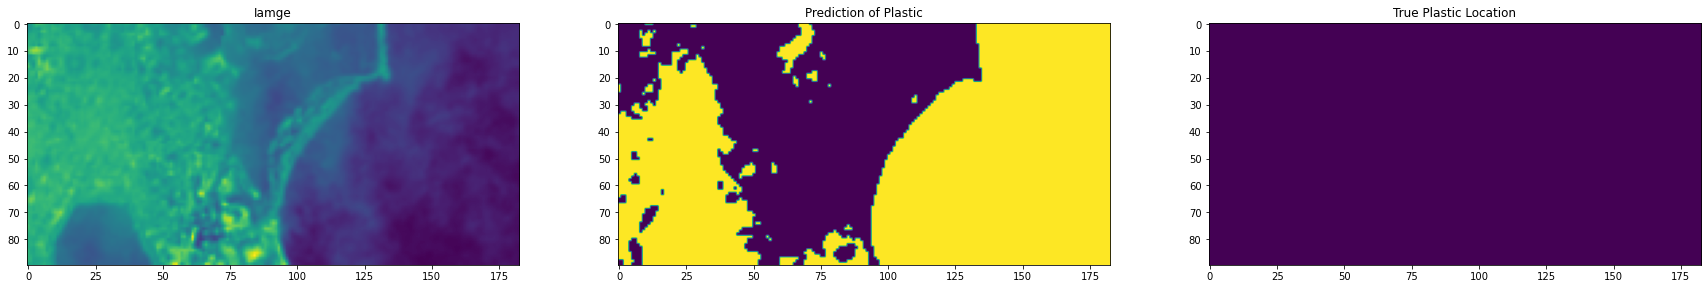

Jaccard score pour l'image 3 : 0.0


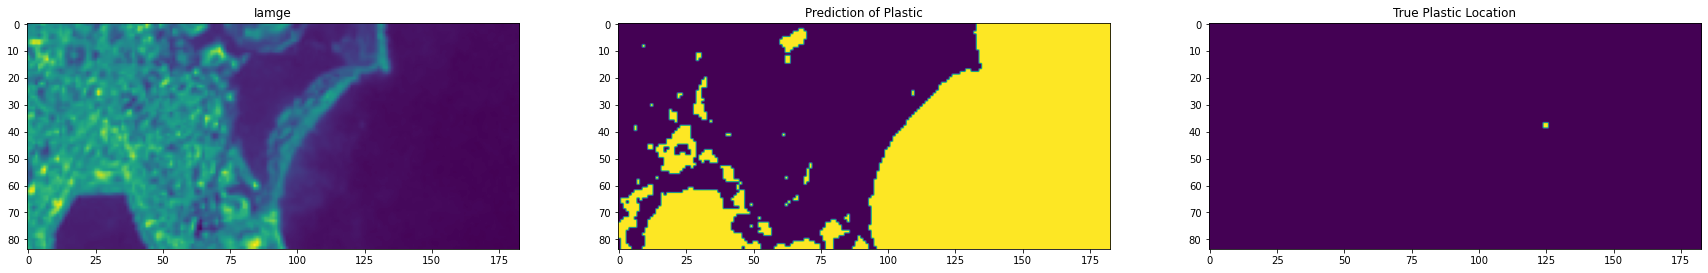

Jaccard score pour l'image 4 : 0.0


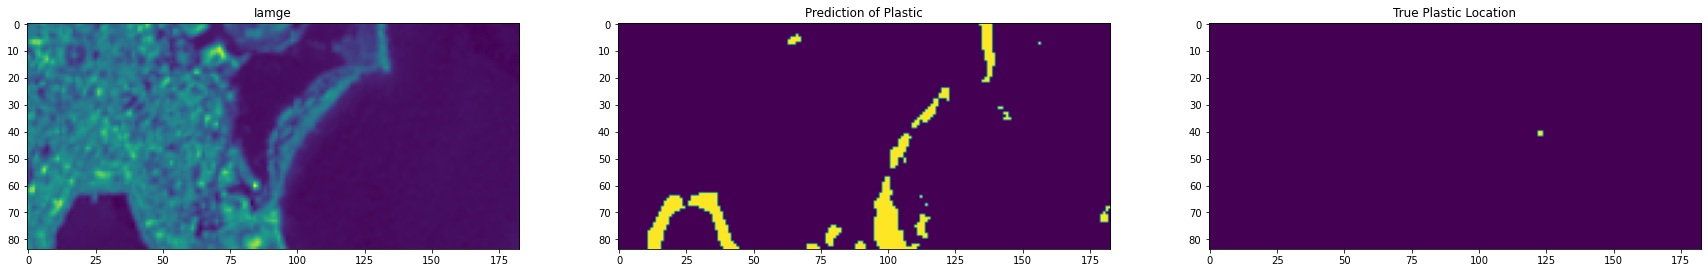

Jaccard score pour l'image 5 : 0.0


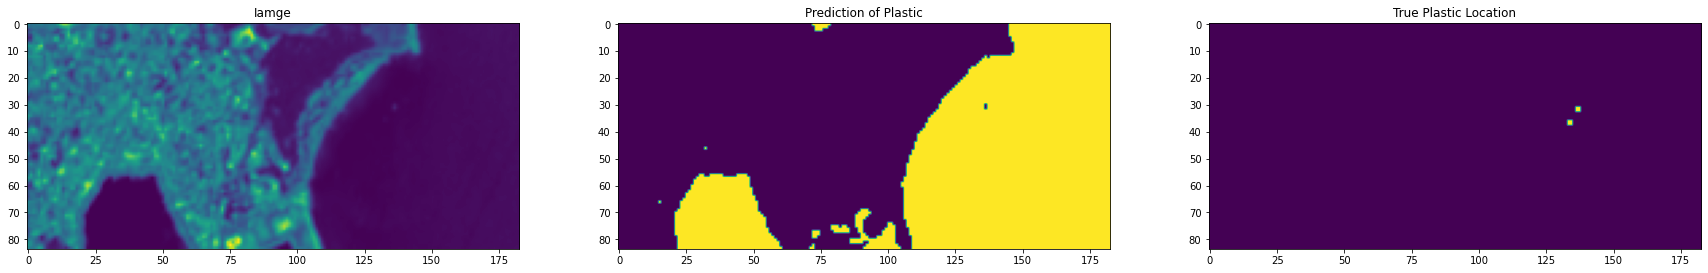

Jaccard score pour l'image 6 : 0.0


In [26]:
for i in range(len(classification_pixel)) :
    y_actual_image = np.array(data_images[i])[3,:].reshape(sizes[i])
    y_predict= np.array(classification_pixel[i]).reshape(sizes[i])
    y_true = np.array(labels_images[i]).reshape(sizes[i])
    
    ### Evaluation des métriques 
    
    f = plt.figure(figsize=(30,30))
    f.add_subplot(1,3, 1)
    plt.title("Iamge")
    plt.imshow(y_actual_image)
    
    f.add_subplot(1,3, 2)
    plt.title("Prediction of Plastic")
    plt.imshow(y_predict)
    
    f.add_subplot(1,3, 3)
    
    plt.title("True Plastic Location")
    plt.imshow(y_true)
    plt.show(block=True)
    
    print("Jaccard score pour l'image "+ str(i+1)+ " : " +  str(int(100*jaccard_score(y_true, y_predict, average='micro'))/100))


Les resultats ne sont pas bons du tout. Les predictions ne devraient identifier que du plastique mais ici la labelisation plastique est aussi accordée à de la terre. Comme le montre le jaccard-score

In [91]:
### Testons sur l'image planet 
image = tifffile.imread(data_planet+ img_name_planet[0])
label = tifffile.imread(data_planet+ img_name_planet[1])

In [ ]:
image_table = image.flatten()

On pourra trouver ci-joint un code permettant pour faire du spectral https://github.com/savasozkan/dscn qui devrait être disponible à l'avenir.